# Comparing different h (hidden layers) and λ (L2 regularization) values in a Neural Network

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

#from ipynb.fs.full.supervised_learning import regularize_data it runs the whole file instead of importing just the funtion i want

In [4]:
#receives a csv and returns a regularized dataframe
def regularize_data(file):
    df = pd.read_csv(file)
    df_copy = df.copy()
    continuous_features = ['sbp', 'tobacco', 'ldl', 'adiposity','typea', 'obesity', 'alcohol', 'age']

    for feat in continuous_features:
        #shifts the values to have mean 0 and std 1
        df_copy[feat] = (df[feat] - df[feat].mean()) / df[feat].std()

    #normalize non continuous features
    df_copy['famhist'] = df_copy['famhist'].map({'Present': 1, 'Absent': 0})

    return df_copy


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best params: {'model__h': 16, 'model__l2_lambda': 0.1}
Best CV MAE: 0.39526747657483635
Saved best model to models/ann_adiposity_best.keras


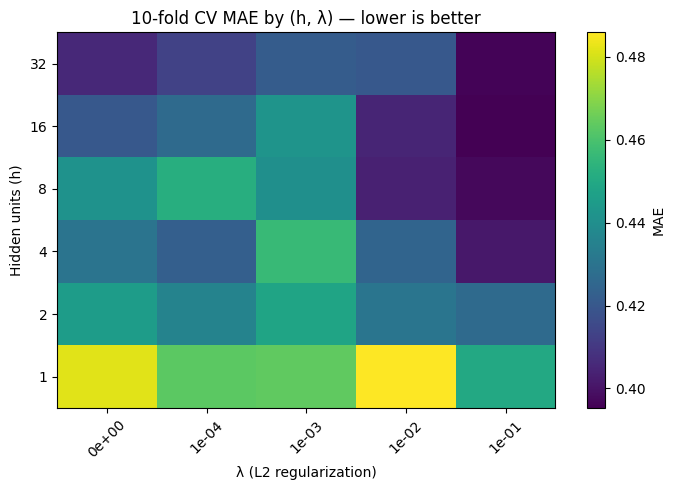

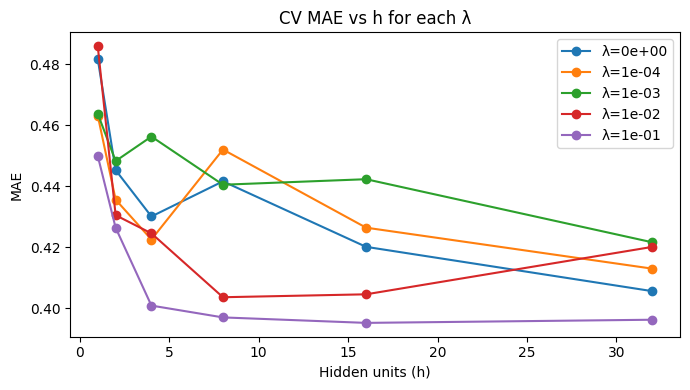

Best h=16, λ=0.1, CV MAE=0.395


In [ ]:

df = regularize_data("data.csv")
#df = pd.read_csv("data.csv")
#df['famhist'] = df['famhist'].map({'Present': 1, 'Absent': 0})
target = 'adiposity'

drop_cols = ["row.names"]
X = df.drop(columns=[target] + drop_cols)
y = df[target]
X_np = np.asarray(X)
y_np = np.asarray(y)

def build_ann(n_features_in_ = X_np.shape[1], h=1, l2_lambda=0.0):
    model = Sequential([
        Dense(h, activation="relu",
              input_shape=(n_features_in_,),
              kernel_regularizer=regularizers.l2(l2_lambda)),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

reg = KerasRegressor(
    model=build_ann,
    model__n_features_in_=X_np.shape[1],   # pass input size explicitly
    epochs=300,
    batch_size=32,
    verbose=0,
    validation_split=0.2,                  # only for early stopping signal
    fit__callbacks=[early],
)

param_grid = {
    "model__h":        [1, 2, 4, 8, 16, 32],
    "model__l2_lambda":[0.0, 1e-4, 1e-3, 1e-2, 1e-1],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    refit=True,   # after search, refit best (on full data)
)

gs.fit(X_np, y_np)

print("Best params:", gs.best_params_)
print("Best CV MAE:", -gs.best_score_)

# Access and save the refit (best) model
best_model = gs.best_estimator_.model_
best_model.save("models/ann_adiposity_best.keras")
print("Saved best model to models/ann_adiposity_best.keras")

cvres = pd.DataFrame(gs.cv_results_).copy()
cvres["MAE"] = -cvres["mean_test_score"]            # convert from sklearn's neg score
cvres["h"] = cvres["param_model__h"].astype(int)
cvres["lambda"] = cvres["param_model__l2_lambda"].astype(float)

# Pivot to a matrix: rows = h, cols = lambda
heat = cvres.pivot(index="h", columns="lambda", values="MAE").sort_index().sort_index(axis=1)

# Heatmap (lower MAE is better)
plt.figure(figsize=(7, 5))
im = plt.imshow(heat.values, aspect="auto", origin="lower")
plt.xticks(range(heat.shape[1]), [f"{v:.0e}" for v in heat.columns], rotation=45)
plt.yticks(range(heat.shape[0]), heat.index)
plt.xlabel("λ (L2 regularization)")
plt.ylabel("Hidden units (h)")
plt.title("10-fold CV MAE by (h, λ) — lower is better")
plt.colorbar(im, label="MAE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
for lam, grp in cvres.groupby("lambda"):
    grp = grp.sort_values("h")
    plt.plot(grp["h"], grp["MAE"], marker="o", label=f"λ={lam:.0e}")
plt.xlabel("Hidden units (h)")
plt.ylabel("MAE")
plt.title("CV MAE vs h for each λ")
plt.legend()
plt.tight_layout()
plt.show()

best_row = cvres.loc[cvres["MAE"].idxmin()]
print(f"Best h={int(best_row['h'])}, λ={best_row['lambda']}, CV MAE={best_row['MAE']:.3f}")